# Object-based colocalization

In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "locan",
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "shapely",
#     "tifffile",
# ]
# ///

# Description
In this Notebook...

## Objectives
Learn about mean nearest neighbor, the nearest neighbor function, and Ripley's K function.  
Learn Monte Carlo based validation. 

## Table of Contents
0. Load the data
1. Plot the data
2. Mean nearest neighbor distance
3. Nearest neighbor function
4. Ripley's K - with and without boundary correction
6. Validation - the null distance
7. Validation - Monte Carlo based null hypothesis testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from shapely.geometry import Point, box

## 0. Load the data

In [3]:
# Completely random
n = 400
fall_med_iac = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c1.npy"
)

fall_med_bob = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c2.npy"
)

# 1:1 corresponding points
fall_cold_iac = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_dual_1.npy"
)

fall_cold_bob = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_dual_2.npy"
)

# Min dist
fall_warm_iac = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c1_rep.npy"
)

fall_warm_bob = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_{n}_c2_rep.npy"
)

# Gaussian, uncorrelated
winter_warm_iac = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c1.npy"
)

winter_warm_bob = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c2.npy"
)

# Gaussian, correlated channels
winter_cold_iac = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c1_cor.npy"
)

winter_cold_bob = np.load(
    f"/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_{n}_c2_cor.npy"
)

## 1. Plot the data

In [4]:
def plotloc_2c(
    fall_med_iac: np.ndarray,
    fall_med_bob: np.ndarray,
    title: str,
    s: float = 15,
    ch1: str = "IAC",
    ch2: str = "BOB",
) -> None:
    """
    Plot two channels in a 2D space.
    Parameters:
    fall_med_iac (np.ndarray): Points for channel 1.
    fall_med_bob (np.ndarray): Points for channel 2.
    """
    plt.scatter(
        fall_med_iac[:, 0], fall_med_iac[:, 1], c="blue", label=ch1, s=s, alpha=1
    )
    plt.scatter(
        fall_med_bob[:, 0],
        fall_med_bob[:, 1],
        c="magenta",
        label=ch2,
        s=s,
        alpha=0.75,
        marker="s",
    )
    plt.title(label=title)
    plt.legend()

    plt.xlabel("x [au]")
    plt.ylabel("y [au]")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

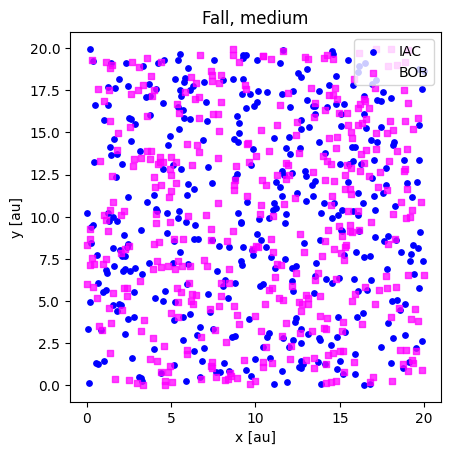

In [5]:
plotloc_2c(fall_med_iac, fall_med_bob, title="Fall, medium")

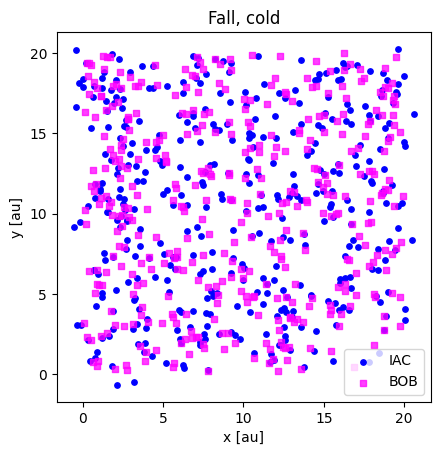

In [6]:
plotloc_2c(fall_cold_iac, fall_cold_bob, title="Fall, cold")

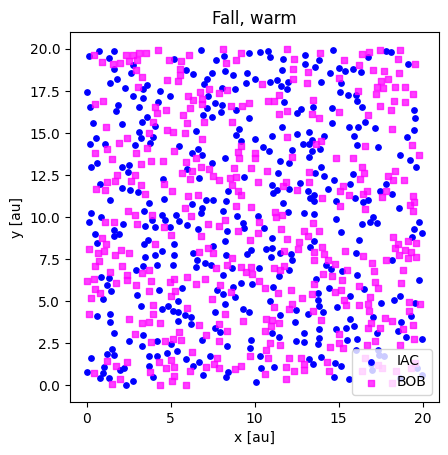

In [7]:
plotloc_2c(fall_warm_iac, fall_warm_bob, title="Fall, warm")

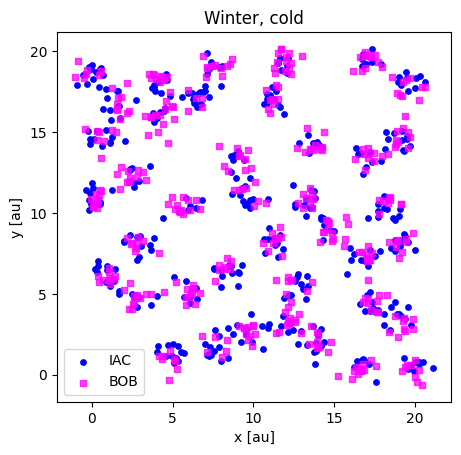

In [8]:
plotloc_2c(winter_cold_iac, winter_cold_bob, title="Winter, cold")

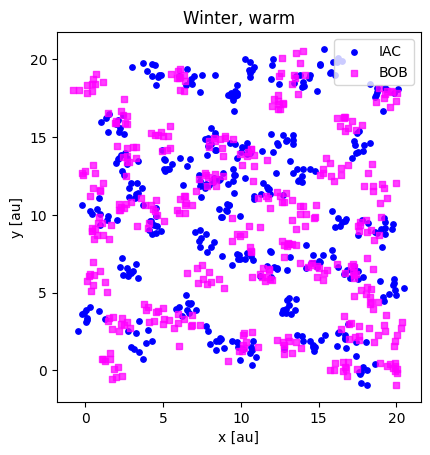

In [9]:
plotloc_2c(winter_warm_iac, winter_warm_bob, title="Winter, warm")

## 2. Mean nearest neighbour distance

In [10]:
def meanNN(points1: np.ndarray, points2: np.ndarray) -> tuple[np.ndarray, float]:
    """
    Computes the mean nearest neighbour distance for a set of 2D points.
    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points; if None, uses points1

    Returns:
    - min_dists: array of minimum distances of each point in points1 to its nearest neighbour in points2
    - mean_nn: mean of the minimum distances
    """

    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(d12, np.inf)

    min_dists = np.min(d12, axis=1)
    mean_nn = np.mean(min_dists)

    return min_dists, mean_nn

### Compute Fall samples

In [11]:
nndist_fall_med, meannn_fall_med = meanNN(fall_med_iac, fall_med_bob)
nndist_fall_cold, meannn_fall_cold = meanNN(fall_cold_iac, fall_cold_bob)
nndist_fall_warm, meannn_fall_warm = meanNN(fall_warm_iac, fall_warm_bob)

### Plot Fall samples

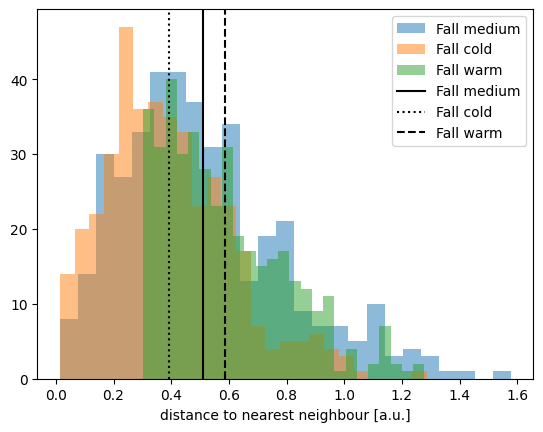

In [12]:
plt.hist(nndist_fall_med, label="Fall medium", alpha=0.5, bins=25)
plt.hist(nndist_fall_cold, label="Fall cold", alpha=0.5, bins=25)
plt.hist(nndist_fall_warm, label="Fall warm", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbour [a.u.]")
plt.axvline(meannn_fall_med, c="k", linestyle="-", label="Fall medium")
plt.axvline(meannn_fall_cold, c="k", linestyle=":", label="Fall cold")
plt.axvline(meannn_fall_warm, c="k", linestyle="--", label="Fall warm")
plt.legend()

### Compute Winter samples

In [13]:
nndist_winter_warm, meannn_winter_warm = meanNN(winter_warm_iac, winter_warm_bob)
nndist_winter_cold, meannn_winter_cold = meanNN(winter_cold_iac, winter_cold_bob)

### Plot Winter samples

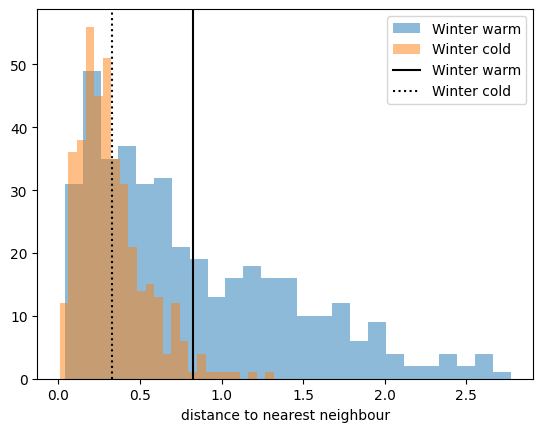

In [14]:
plt.hist(nndist_winter_warm, label="Winter warm", alpha=0.5, bins=25)
plt.hist(nndist_winter_cold, label="Winter cold", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbour")
plt.axvline(meannn_winter_warm, c="k", linestyle="-", label="Winter warm")
plt.axvline(meannn_winter_cold, c="k", linestyle=":", label="Winter cold")
plt.legend()

## 3. Nearest neighbour function

In [15]:
def nearest_neighbour_function(
    points1: np.ndarray, points2: np.ndarray, radii: np.ndarray
) -> np.ndarray:
    """
    Computes the nearest neighbour function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate the nearest neighbour function
    Returns:
    - S: array of nearest neighbour function values at each radius
    - mu0: array of expected values under the null model at each radius
    """

    # calculate area based on bounding box of all points
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)
    min_x, min_y = np.min(allpoints, axis=0)
    (max_x - min_x) * (max_y - min_y)

    n1 = len(points1)  # number of points in the first set
    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(
            d12, np.inf
        )  # Set diagonal to infinity to ignore self-distances

    min_dists = np.min(d12, axis=1)  # nearest neighbour distances per point

    S = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        within_r = min_dists < r
        n_within_r = len(min_dists[within_r])
        S[i] = n_within_r / n1

    return S

In [57]:
def plot_nn_function(
    s: np.ndarray,
    radii: np.ndarray,
    nulldist: np.ndarray = None,
    show: bool = True,
    label: str = "observed",
    line: str = "-",
) -> None:
    """Plots the nearest neighbour function S(r) with optional null model mean.
    Parameters:
    - s: array of S(r) values
    - radii: array of radii at which S(r) is evaluated
    - nulldist: optional array of null model mean values; if provided, plotted in red
    - show: if True, displays the plot; if False, only prepares the plot
    - label: label for the S(r) line in the plot
    - line: line style for the S(r) plot; default is solid line
    """
    if nulldist is not None:
        plt.plot(radii, nulldist, c="red", alpha=0.5, label="null‐model mean")

    plt.plot(radii, s, c="black", alpha=0.8, label=f"{label}", linestyle=line)

    plt.legend()
    plt.xlabel("radius (r)")
    plt.ylabel("S(r)")
    plt.tight_layout()
    if show:
        plt.show()

### Define radii for which to evaluate the nearest neighbor function

In [58]:
radii = np.arange(0.1, 3, 0.01)

#### Inspect the fall samples

In [59]:
s_fall_med = nearest_neighbour_function(fall_med_iac, fall_med_bob, radii)
s_fall_warm = nearest_neighbour_function(fall_warm_iac, fall_warm_bob, radii)
s_fall_cold = nearest_neighbour_function(fall_cold_iac, fall_cold_bob, radii)

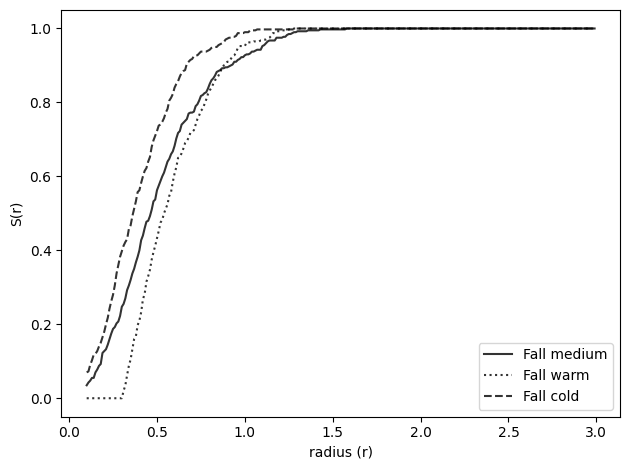

In [60]:
plot_nn_function(s_fall_med, radii, show=False, label="Fall medium", line="-")
plot_nn_function(s_fall_warm, radii, show=False, label="Fall warm", line=":")
plot_nn_function(s_fall_cold, radii, show=False, label="Fall cold", line="--")

#### Inspect the winter samples

In [20]:
S_winter_warm = nearest_neighbour_function(winter_warm_iac, winter_warm_bob, radii)
S_winter_cold = nearest_neighbour_function(winter_cold_iac, winter_cold_bob, radii)

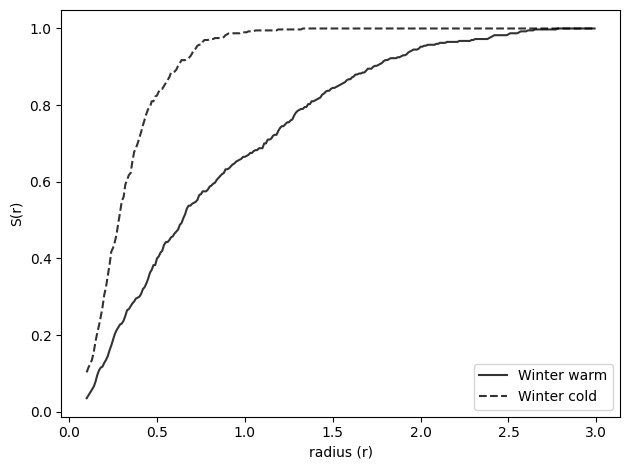

In [21]:
plot_nn_function(S_winter_warm, radii, show=False, label="Winter warm")
plot_nn_function(S_winter_cold, radii, show=True, label="Winter cold", line="--")

## 4. Ripley's K function

In [22]:
def ripleys_k_function(
    points1: np.ndarray,
    points2: np.ndarray,
    radii: np.ndarray,
    area=None,
    edge_correction=False,
) -> np.ndarray:
    """
    Computes Ripley's K function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate K
    - area: total area of the observation window; if None, calculated from bounding box
    - edge_correction: if True, applies basic border edge correction

    Returns:
    - ks: K-function values at each radius
    """

    n1 = len(points1)
    n2 = len(points2)
    ks = np.zeros_like(radii, dtype=float)
    dists = distance_matrix(points1, points2)

    # Compute area if not provided
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)

    if area is None:
        min_x, min_y = np.min(allpoints, axis=0)
        area = (max_x - min_x) * (max_y - min_y)
    else:
        min_x = 0
        min_y = 0
        max_x = np.max([max_x, np.sqrt(area)])
        max_y = np.max([max_y, np.sqrt(area)])

    if edge_correction:
        # Determine FOV area
        square = box(min_x, min_y, max_x, max_y)
        area_correction = np.zeros_like(dists)

        for i in range(n1):
            for j in range(n2):
                circle = Point(points1[i]).buffer(dists[i][j])
                if circle.area == 0 or circle.intersection(square).area == 0:
                    continue  # Avoid division by zero
                area_correction[i][j] = circle.area / circle.intersection(square).area

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(dists, np.inf)

    for i, r in enumerate(radii):
        within_r = dists < r

        if edge_correction:
            within_r = within_r * area_correction

        count_within_r = np.sum(within_r)

        ks[i] = (area / (n1 * n2)) * count_within_r

    return ks

### Define radii for which to compute Ripley's K function

In [23]:
k_radii = np.arange(0.1, 5, 0.1)  # radii for which to compute the K-function

#### Compute K for the fall samples

In [24]:
k_fall_med = ripleys_k_function(
    fall_med_iac, fall_med_bob, radii=k_radii, area=400, edge_correction=False
)

In [25]:
k_fall_cold = ripleys_k_function(
    fall_cold_iac, fall_cold_bob, radii=k_radii, area=400, edge_correction=False
)

In [26]:
k_fall_warm = ripleys_k_function(
    fall_warm_iac, fall_warm_bob, radii=k_radii, area=400, edge_correction=False
)

#### Compute K for the winter samples

In [27]:
k_winter_warm = ripleys_k_function(
    winter_warm_iac, winter_warm_bob, radii=k_radii, area=400, edge_correction=False
)

In [28]:
k_winter_cold = ripleys_k_function(
    winter_cold_iac, winter_cold_bob, radii=k_radii, area=400, edge_correction=False
)

In [29]:
k_winter_cold_iac = ripleys_k_function(
    winter_cold_iac, winter_cold_iac, radii=k_radii, area=400, edge_correction=False
)

#### Inspect the results

In [61]:
def plot_ripleys_k(
    k: np.ndarray,
    radii: np.ndarray,
    label: str = "uniform",
    show: bool = True,
    line: str = "-",
) -> None:
    """
    Plots Ripley's K function.
    Parameters:
    - k: array of K function values
    - radii: array of radii at which K is evaluated
    - label: label for the plot
    - show: whether to show the plot
    - line: line style for the plot
    """
    plt.plot(radii, k, color="k", label=f"{label}, no edge correction", linestyle=line)
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.legend()
    if show:
        plt.show()

#### Fall samples

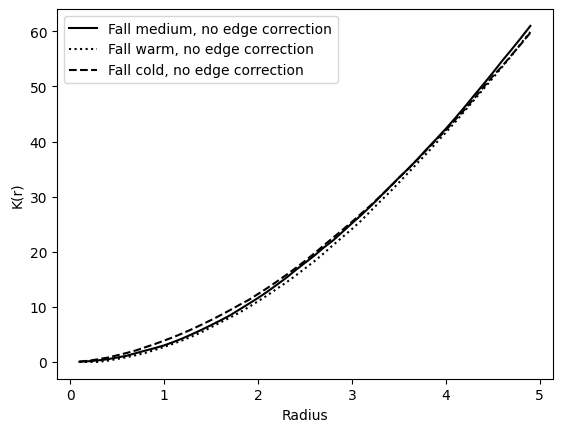

In [62]:
plot_ripleys_k(k_fall_med, k_radii, label="Fall medium", show=False)
plot_ripleys_k(k_fall_warm, k_radii, label="Fall warm", show=False, line=":")
plot_ripleys_k(k_fall_cold, k_radii, label="Fall cold", line="--")

#### Winter samples

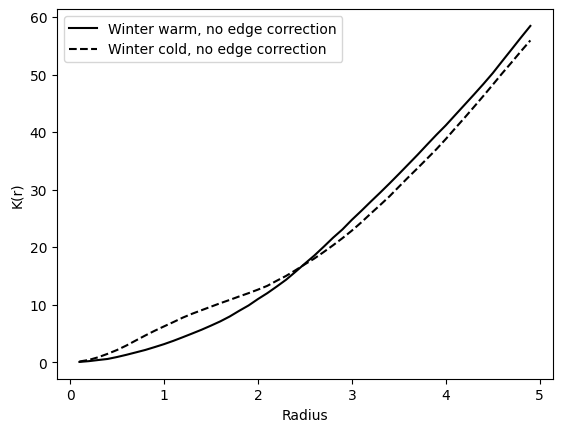

In [63]:
plot_ripleys_k(k_winter_warm, k_radii, label="Winter warm", show=False)
plot_ripleys_k(k_winter_cold, k_radii, label="Winter cold", line="--")

### 4.1 Ripley's K with edge correction

In [68]:
def plot_ripleys_k_ec(
    k: np.ndarray, k_corrected: np.ndarray, radii: np.ndarray, label: str = "uniform"
) -> None:
    """
    Plots Ripley's K function with and without edge correction.
    Parameters:
    - k: array of K function values without edge correction
    - k_corrected: array of K function values with edge correction
    - radii: array of radii at which K function is evaluated
    - label: label for the plot, default is "uniform"
    """
    plt.plot(
        radii,
        k,
        color="k",
        label=f"{label}, no edge correction",
        linestyle="-",
        alpha=0.5,
    )
    plt.plot(
        radii,
        k_corrected,
        color="k",
        label=f"{label}, edge correction",
        linestyle="--",
    )
    plt.title("Ripley's K function")
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.show()

#### Compute the fall samples

In [65]:
k_fall_med_ec = ripleys_k_function(
    fall_med_iac, fall_med_bob, radii=k_radii, area=400, edge_correction=True
)
k_fall_warm_ec = ripleys_k_function(
    fall_warm_iac, fall_warm_bob, radii=k_radii, area=400, edge_correction=True
)

k_fall_cold_ec = ripleys_k_function(
    fall_cold_iac, fall_cold_bob, radii=k_radii, area=400, edge_correction=True
)

#### Compute the winter samples

In [66]:
k_winter_warm_ec = ripleys_k_function(
    winter_warm_iac, winter_warm_bob, radii=k_radii, area=400, edge_correction=True
)

k_winter_cold_ec = ripleys_k_function(
    winter_cold_iac, winter_cold_bob, radii=k_radii, area=400, edge_correction=True
)

#### Plot a Fall samples with edge correction

### Plot the winter samples

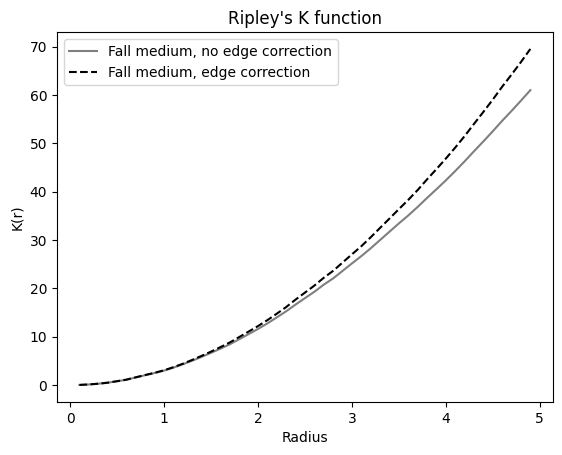

In [70]:
plot_ripleys_k_ec(k_fall_med, k_fall_med_ec, k_radii, label="Fall medium")

#### Plot a Winter samples with edge correction

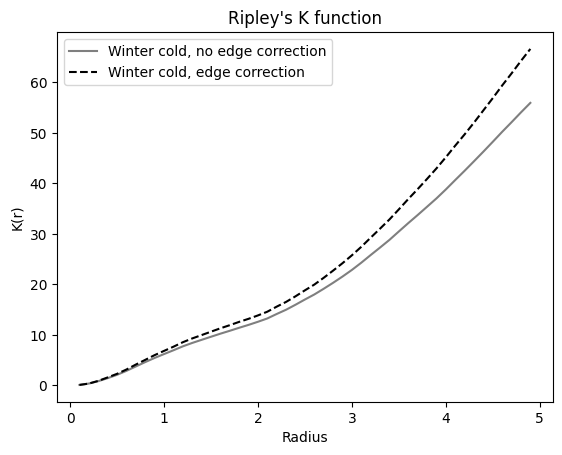

In [71]:
plot_ripleys_k_ec(k_winter_cold, k_winter_cold_ec, k_radii, label="Winter cold")

## 5. Validations - the null distance

### Calculate the null distance of the nearest neighbor function

In [72]:
def getnulldist(n: int, radii: np.ndarray, area: float) -> np.ndarray:
    """
    Computes the expected nearest neighbour distances under a null model for a set of 2D points.
    Parameters:
    - points2: array of shape (n_points, 2) representing the coordinates of the points to compute nearest n
    neighbour distances to
    - radii: array-like of radii at which to evaluate the null model

    Returns:
    - mu0: array of expected nearest neighbour distances at each radius
    """

    mu0 = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        mu0[i] = 1 - np.exp(-(n / area) * np.pi * (r**2))

    return mu0

In [73]:
nulldist = getnulldist(n=400, area=400, radii=radii)

#### Plot the fall samples

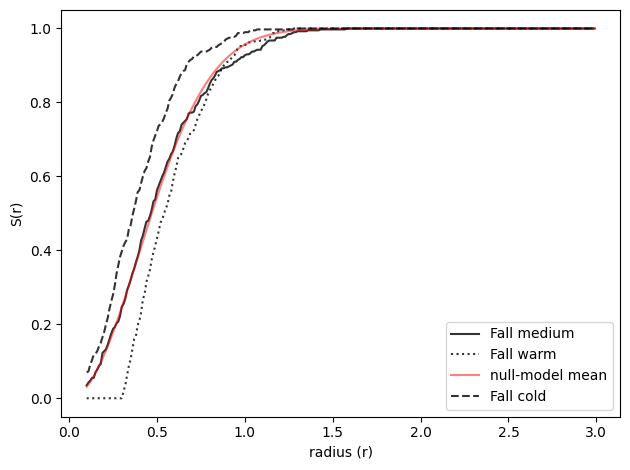

In [74]:
plot_nn_function(s_fall_med, radii, show=False, label="Fall medium", line="-")
plot_nn_function(s_fall_warm, radii, show=False, label="Fall warm", line=":")
plot_nn_function(
    s_fall_cold, radii, show=False, label="Fall cold", line="--", nulldist=nulldist
)

#### Plot the winter samples

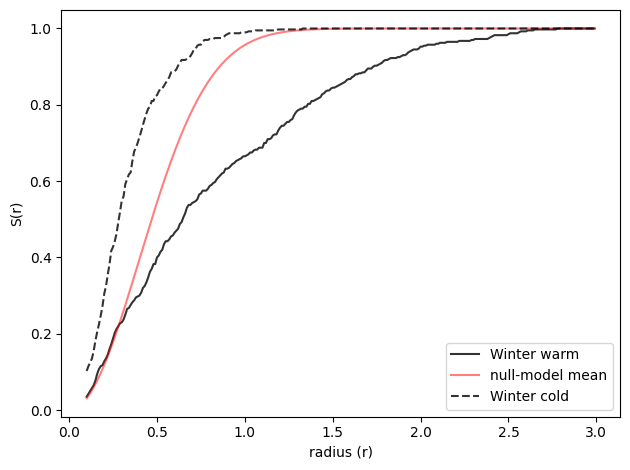

In [75]:
plot_nn_function(S_winter_warm, radii, show=False, label="Winter warm")
plot_nn_function(
    S_winter_cold, radii, show=True, label="Winter cold", line="--", nulldist=nulldist
)

## 6. Validation - Monte-Carlo based null-hypothesis testing

### 6.1 Simulate under the null hypothesis

In [76]:
def sample_uniform_points_batch(
    ndraw: int, num_points: int = 400, x_max: int = 10, y_max: int = 10, seed: int = 42
) -> np.ndarray:
    """
    Generate *ndraw* independent batches of 2-D points drawn from independent
    **uniform random** distributions on the rectangle ``[0, x_max] × [0, y_max]``.

    Unlike a “uniform grid,” the points are *randomly* scattered—each position
    inside the rectangle has equal probability of being chosen.

    Parameters
    ----------
    ndraw : int
        Number of batches to generate.
    num_points : int
        Number of points in each batch.
    x_max : int
        Maximum x-coordinate value.
    y_max : int
        Maximum y-coordinate value.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (ndraw, num_points, 2) containing the generated points.
    """
    rng = np.random.default_rng(seed)

    x = rng.uniform(0, x_max, size=(ndraw, num_points, 1))
    y = rng.uniform(0, y_max, size=(ndraw, num_points, 1))

    return np.concatenate([x, y], axis=-1)

In [77]:
ndraw = 1000  # Sufficiently large for statistics.
num_points = len(fall_med_iac)  # Same number of points as our data
points_multiple = sample_uniform_points_batch(
    ndraw, num_points=num_points, x_max=20, y_max=20
)

#### Inspect the random results

In [78]:
def plotpoints(points: np.ndarray, title: str = "Monte carlo simulated points") -> None:
    """Plots a set of 2D points.
    Parameters:
    - points: array of shape (n_points, 2) representing the coordinates of the points
    - title: title of the plot

    """
    plt.scatter(points[:, 0], points[:, 1], c="k", s=10)
    plt.title(label=title)

    plt.xlabel("x [au]")
    plt.ylabel("y [au]")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

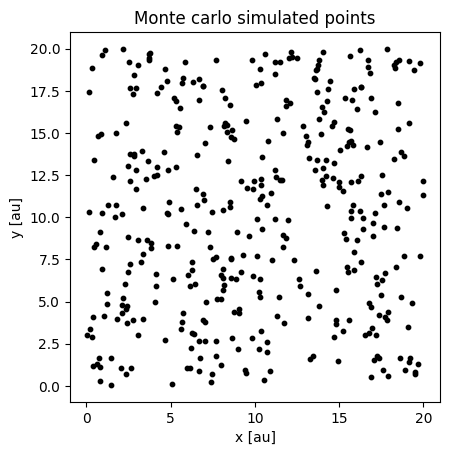

In [82]:
sample_i = 999
plotpoints(points_multiple[sample_i])

### 6.2 Validate - Mean nearest neighbor distance

#### Calculate the mean nearest neighbor distance for each random dataset 

In [84]:
nn_multiple = np.zeros(ndraw, dtype=float)
for i in range(ndraw):  # for all randomly generated samples
    _, mean_i = meanNN(points_multiple[i], points_multiple[i])  # calculate their mean
    nn_multiple[i] = mean_i

#### Define significance level for later testing

In [83]:
alpha = 5  # %
bound_low = alpha / 2
bound_upper = 100 - bound_low
percentile_low = np.percentile(nn_multiple, bound_low)
percentile_high = np.percentile(nn_multiple, bound_upper)

#### Fall samples

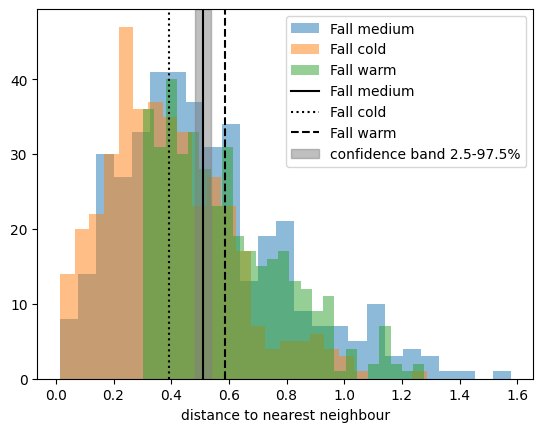

In [85]:
# This is the same code as before
plt.hist(nndist_fall_med, label="Fall medium", alpha=0.5, bins=25)
plt.hist(nndist_fall_cold, label="Fall cold", alpha=0.5, bins=25)
plt.hist(nndist_fall_warm, label="Fall warm", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbour")
plt.axvline(meannn_fall_med, c="k", linestyle="-", label="Fall medium")
plt.axvline(meannn_fall_cold, c="k", linestyle=":", label="Fall cold")
plt.axvline(meannn_fall_warm, c="k", linestyle="--", label="Fall warm")

# Now we display the confidence bounds
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

#### Winter samples

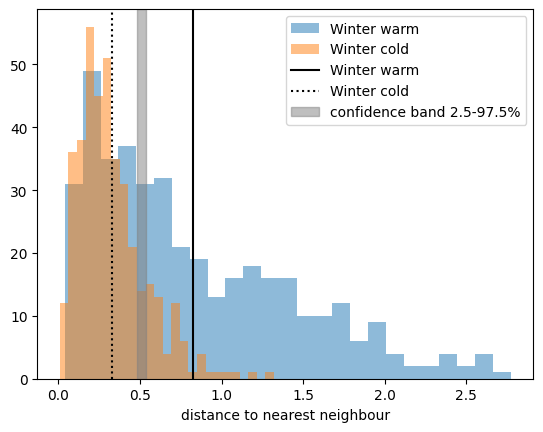

In [86]:
plt.hist(nndist_winter_warm, label="Winter warm", alpha=0.5, bins=25)
plt.hist(nndist_winter_cold, label="Winter cold", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbour")
plt.axvline(meannn_winter_warm, c="k", linestyle="-", label="Winter warm")
plt.axvline(meannn_winter_cold, c="k", linestyle=":", label="Winter cold")
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

### 6.3 Validate - Nearest neighbor function

#### Define a plotting function for the Nearest Neighbor function

In [91]:
def plot_envelope(
    s: np.ndarray,
    s_multiple: np.ndarray,
    radii: np.ndarray,
    alpha: float = 5,
    label: str = "data",
    metric: str = "K(r)",
    show: bool = True,
    linestyle: str = "-",
):
    """
    Plots the envelope of a metric (e.g., Nearest neighbor function, or K-function) with confidence intervals.
    Parameters:
    - s: array of metric values for the observed data
    - s_multiple: array of metric values for multiple realizations (i.e. of monte Carlo simulations)
    - radii: array of radii at which the metric is evaluated
    - alpha: significance level for the confidence interval (default is 5)
    - label: label for the observed data in the plot
    - metric: name of the metric being plotted (default is "K(r)" for ripley's K function)
    - show: whether to show the plot (default is True).
    If False, the plot is not shown but can be saved or further processed.
    """
    if show:  # show confidence intervals
        ndraw = len(s_multiple)
        s_multiple_mean = np.mean(s_multiple, axis=0)
        bound_low = alpha / 2
        bound_upper = 100 - bound_low
        percentiles_low = np.percentile(s_multiple, bound_low, axis=0)
        percentiles_high = np.percentile(s_multiple, bound_upper, axis=0)

        plt.plot(  # plot the mean of the multiple realizations
            radii,
            s_multiple_mean,
            color="grey",
            label=f"mean of {ndraw} realizations",
        )

        plt.fill_between(  # fill the area between the percentiles
            radii,
            percentiles_low,
            percentiles_high,
            color="grey",
            alpha=0.3,
            label=f"{bound_low}-{bound_upper}% quantile range",
        )

    plt.plot(
        radii, s, label=label, color="k", linestyle=linestyle
    )  # plot the observed data
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel(f"{metric}")
    if show:
        plt.show()

### Compute the nearest neighbor function for all random samples

In [93]:
s_multiple = np.zeros([ndraw, len(radii)], dtype=float)
for i in range(ndraw):
    s_multiple[i] = nearest_neighbour_function(
        points_multiple[i], points_multiple[i], radii
    )

#### Fall samples

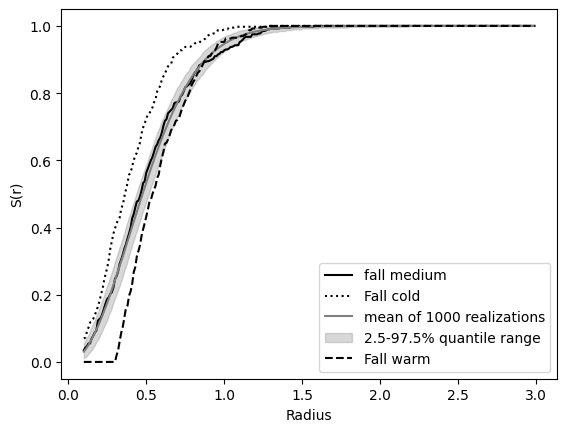

In [94]:
plot_envelope(
    s_fall_med, s_multiple, radii=radii, metric="S(r)", label="Fall medium", show=False
)
plot_envelope(
    s_fall_cold,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Fall cold",
    linestyle=":",
    show=False,
)
plot_envelope(
    s_fall_warm,
    s_multiple,
    radii=radii,
    metric="S(r)",
    linestyle="--",
    label="Fall warm",
)

#### Winter samples

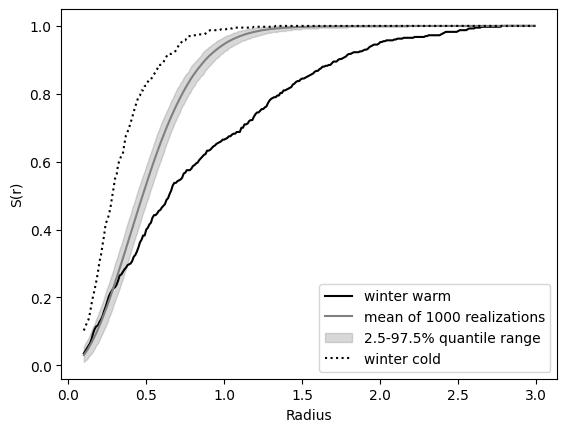

In [95]:
plot_envelope(
    S_winter_warm,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter warm",
    show=False,
)
plot_envelope(
    S_winter_cold,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter cold",
    linestyle=":",
)

### 6.4 Validate - Ripley's K

Here, we can reuse the sample plotting function as defined for the nearest neighbor function

#### Compute Ripley's K for all randomly generated samples

In [96]:
ks_multiple = np.zeros([ndraw, len(k_radii)], dtype=float)
for i in range(ndraw):
    ks_multiple[i] = ripleys_k_function(
        points_multiple[i],
        points_multiple[i],
        radii=k_radii,
        area=400,
        edge_correction=False,
    )

#### Fall samples

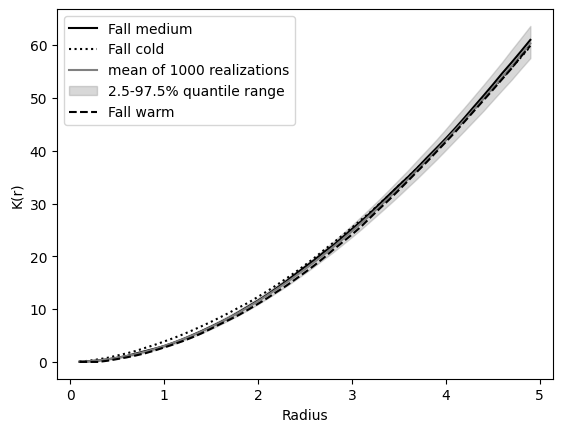

In [98]:
plot_envelope(
    k_fall_med,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Fall medium",
    show=False,
)
plot_envelope(
    k_fall_cold,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Fall cold",
    show=False,
    linestyle=":",
)
plot_envelope(
    k_fall_warm,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Fall warm",
    linestyle="--",
)

#### Winter samples

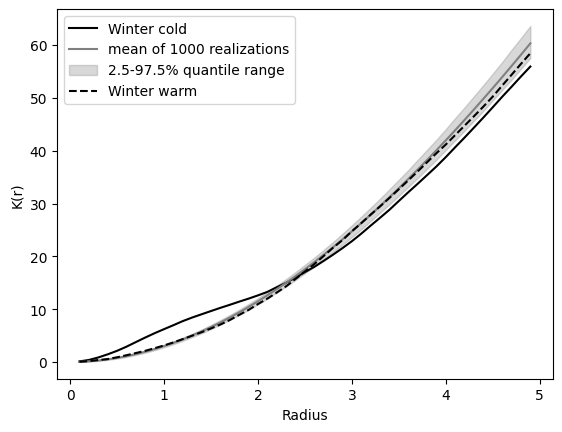

In [100]:
plot_envelope(
    k_winter_cold,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Winter cold",
    show=False,
)
plot_envelope(
    k_winter_warm,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Winter warm",
    linestyle="--",
)